# 矩形波导横向电磁场分布示意
本笔记实现通用的矩形波导 TE/TM 模式场分布计算与绘制：给定波导尺寸、工作频率与模式指数 $(m,n)$，即可输出横向电磁场线示意。其中电场线使用实线、磁场线使用虚线，并展示矩形波导截面边框。

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

MU0 = 4 * np.pi * 1e-7
EPS0 = 8.854187817e-12
C0 = 1 / np.sqrt(MU0 * EPS0)


def compute_transverse_fields(mode: str, m: int, n: int, a: float, b: float, freq: float, *, amplitude: float = 1.0, grid: int = 200, phase: float = np.pi / 2, z: float = 0.0):
    """Return transverse field components on an x-y grid for TE/TM modes."""
    mode = mode.upper()
    if mode.startswith("TE") and (m == 0 and n == 0):
        raise ValueError("TE 模式至少需要 m 或 n 不为 0")
    if mode.startswith("TM") and (m == 0 or n == 0):
        raise ValueError("TM 模式需要 m 与 n 均非零")
    if not mode.startswith(("TE", "TM")):
        raise ValueError("mode 仅支持 TE / TM")

    x = np.linspace(0.0, a, grid)
    y = np.linspace(0.0, b, grid)
    X, Y = np.meshgrid(x, y, indexing="xy")

    omega = 2 * np.pi * freq
    kc_sq = (m * np.pi / a) ** 2 + (n * np.pi / b) ** 2
    if kc_sq == 0:
        raise ValueError("k_c^2 不能为 0")
    k = omega / C0
    kz = np.sqrt((k**2 - kc_sq) + 0j)  # 允许高于或低于截止，保持复数形式
    phase_factor = np.exp(1j * (kz * z + phase))

    cos_mx = np.cos(m * np.pi * X / a)
    sin_mx = np.sin(m * np.pi * X / a)
    cos_ny = np.cos(n * np.pi * Y / b)
    sin_ny = np.sin(n * np.pi * Y / b)

    if mode.startswith("TE"):
        H0 = amplitude
        Ez = np.zeros_like(X, dtype=complex)
        Hz = H0 * cos_mx * cos_ny * phase_factor
        Ex = (-1j * omega * MU0 / kc_sq) * (n * np.pi / b) * H0 * cos_mx * sin_ny * phase_factor
        Ey = (1j * omega * MU0 / kc_sq) * (m * np.pi / a) * H0 * sin_mx * cos_ny * phase_factor
        Hx = (-1j * kz / kc_sq) * (m * np.pi / a) * H0 * sin_mx * cos_ny * phase_factor
        Hy = (-1j * kz / kc_sq) * (n * np.pi / b) * H0 * cos_mx * sin_ny * phase_factor
    else:  # TM 模式
        E0 = amplitude
        Ez = E0 * sin_mx * sin_ny * phase_factor
        Hz = np.zeros_like(X, dtype=complex)
        Ex = (1j * kz / kc_sq) * (m * np.pi / a) * E0 * cos_mx * sin_ny * phase_factor
        Ey = (1j * kz / kc_sq) * (n * np.pi / b) * E0 * sin_mx * cos_ny * phase_factor
        Hx = (-1j * omega * EPS0 / kc_sq) * (n * np.pi / b) * E0 * sin_mx * cos_ny * phase_factor
        Hy = (1j * omega * EPS0 / kc_sq) * (m * np.pi / a) * E0 * cos_mx * sin_ny * phase_factor

    data = {
        "x": x,
        "y": y,
        "Ex": np.real(Ex),
        "Ey": np.real(Ey),
        "Hx": np.real(Hx),
        "Hy": np.real(Hy),
        "Ez": np.real(Ez),
        "Hz": np.real(Hz),
        "kz": kz,
        "mode": mode,
        "m": m,
        "n": n,
        "a": a,
        "b": b,
    }
    return data


def plot_waveguide_mode(mode: str, m: int, n: int, *, a: float = 0.02286, b: float = 0.01016, freq: float = 12e9, amplitude: float = 1.0, grid: int = 200, density: float = 1.2, phase: float = np.pi / 2, z: float = 0.0, figsize=(12, 5.5), dpi: int = 220):
    """Plot transverse electric (solid) and magnetic (dashed) field lines with adjustable figure size/dpi."""
    fields = compute_transverse_fields(mode, m, n, a, b, freq, amplitude=amplitude, grid=grid, phase=phase, z=z)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    e_stream = ax.streamplot(fields["x"], fields["y"], fields["Ex"], fields["Ey"], color="tab:blue", linewidth=1.5, density=density)
    h_stream = ax.streamplot(fields["x"], fields["y"], fields["Hx"], fields["Hy"], color="tab:orange", linewidth=1.3, density=density)
    h_stream.lines.set_linestyle((0, (6, 3)))

    rect = Rectangle((0.0, 0.0), a, b, linewidth=2.2, edgecolor="black", facecolor="none")
    ax.add_patch(rect)

    ax.set_xlim(-0.05 * a, 1.05 * a)
    ax.set_ylim(-0.05 * b, 1.05 * b)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("x (m)", fontsize=12)
    ax.set_ylabel("y (m)", fontsize=12)
    title = f"{fields['mode']}_{fields['m']}{fields['n']} at {freq / 1e9:.2f} GHz"
    ax.set_title(title, fontsize=14)

    legend_handles = [
        Line2D([], [], color="tab:blue", lw=1.5, label="E Field Line (solid)"),
        Line2D([], [], color="tab:orange", lw=1.5, linestyle=(0, (6, 3)), label="H Field Line (dashed)"),
        Line2D([], [], color="black", lw=2.0, label="Waveguide Boundary"),
    ]
    ax.legend(handles=legend_handles, loc="upper right", fontsize=11)
    ax.tick_params(labelsize=11)
    ax.grid(False)
    plt.tight_layout()
    return fig, ax

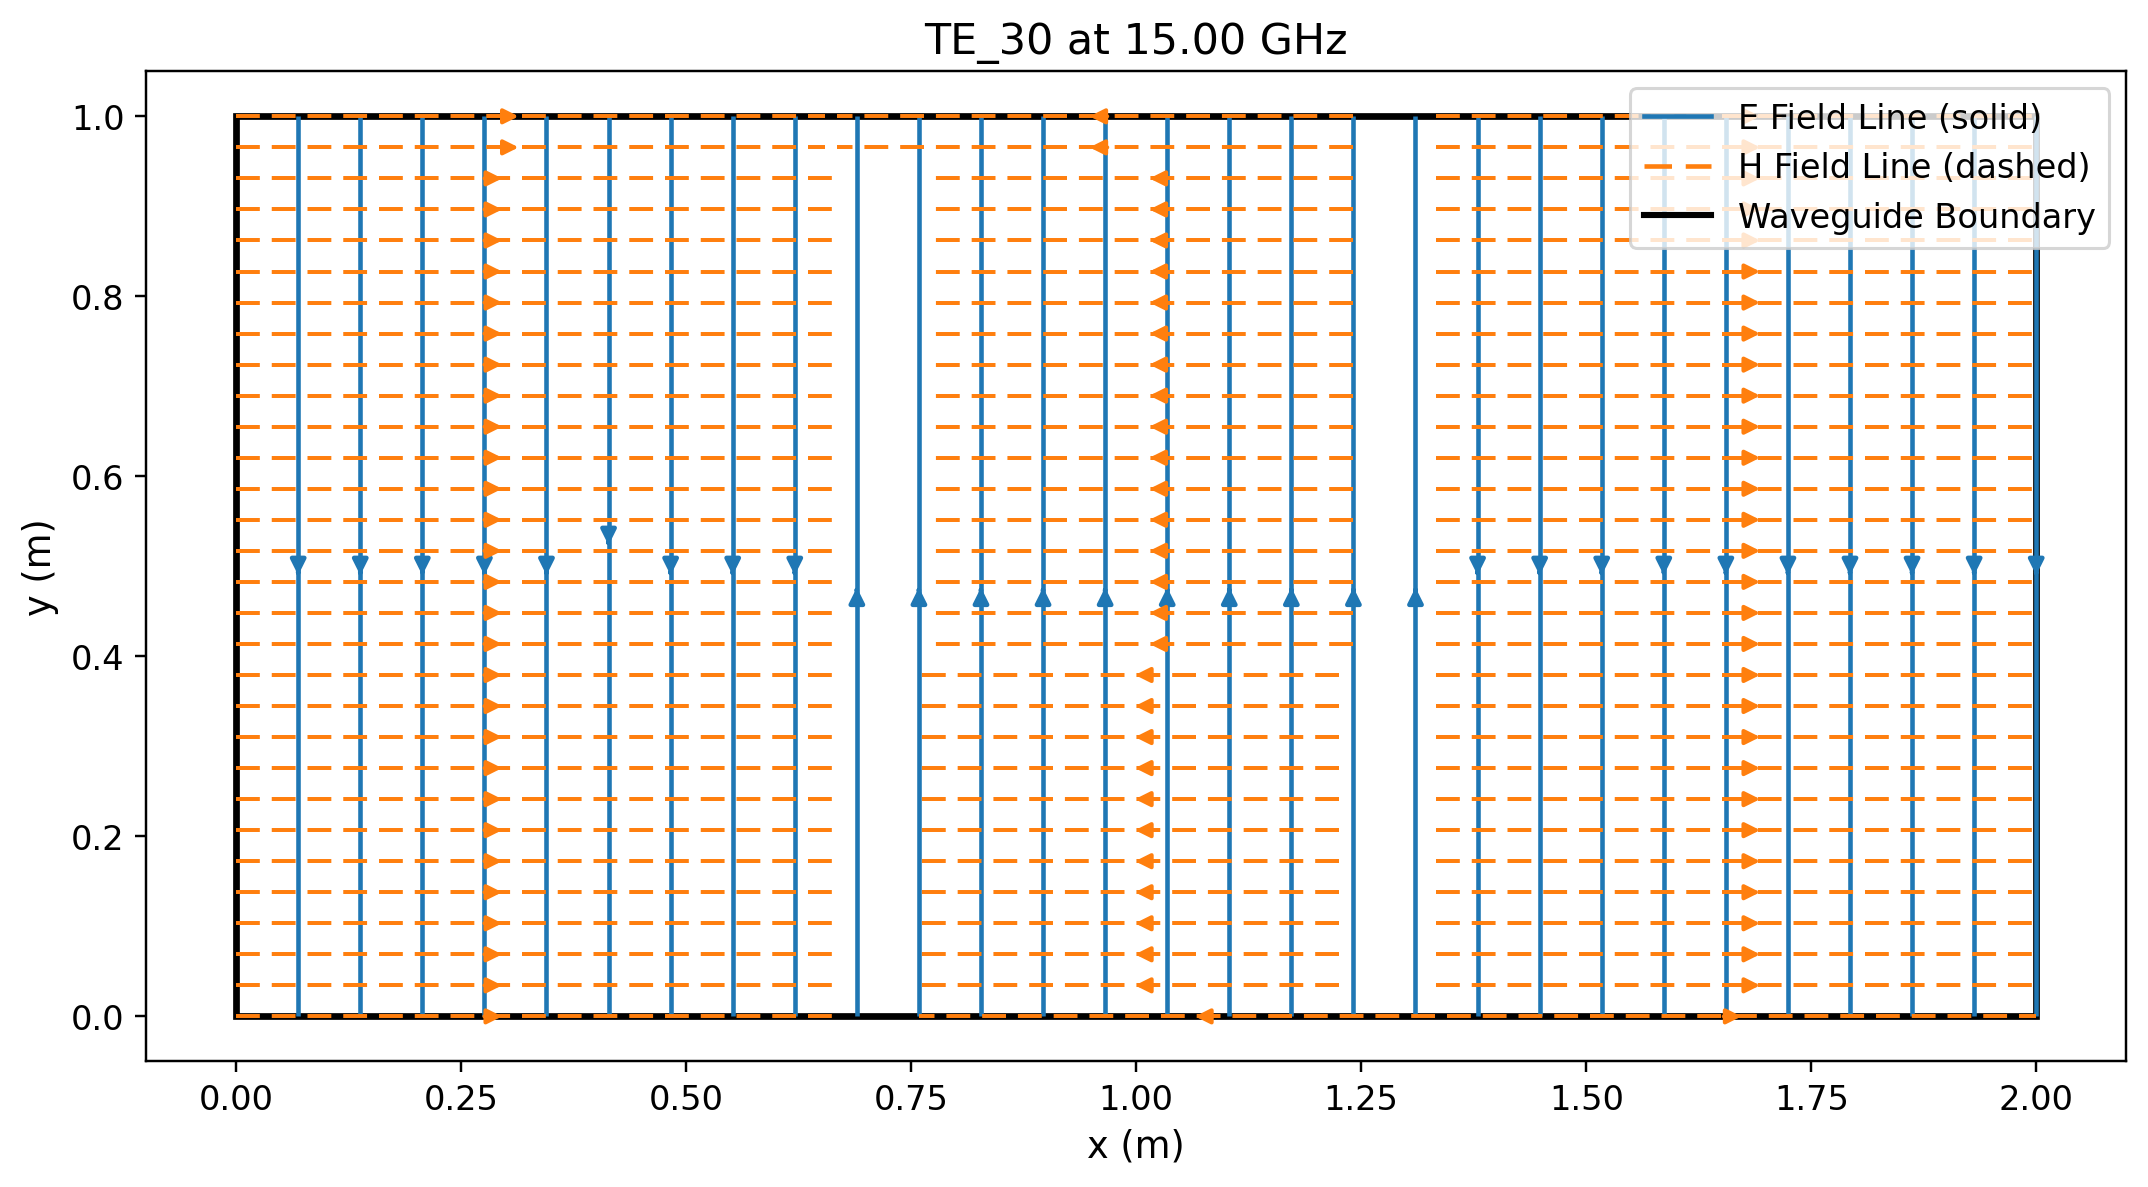

In [31]:

plot_waveguide_mode(
    mode="TE",
    m=3,
    n=0,
    a=2,
    b=1,
    freq=15e9,
    amplitude=1.0,
    grid=1000,
    density=1,
);

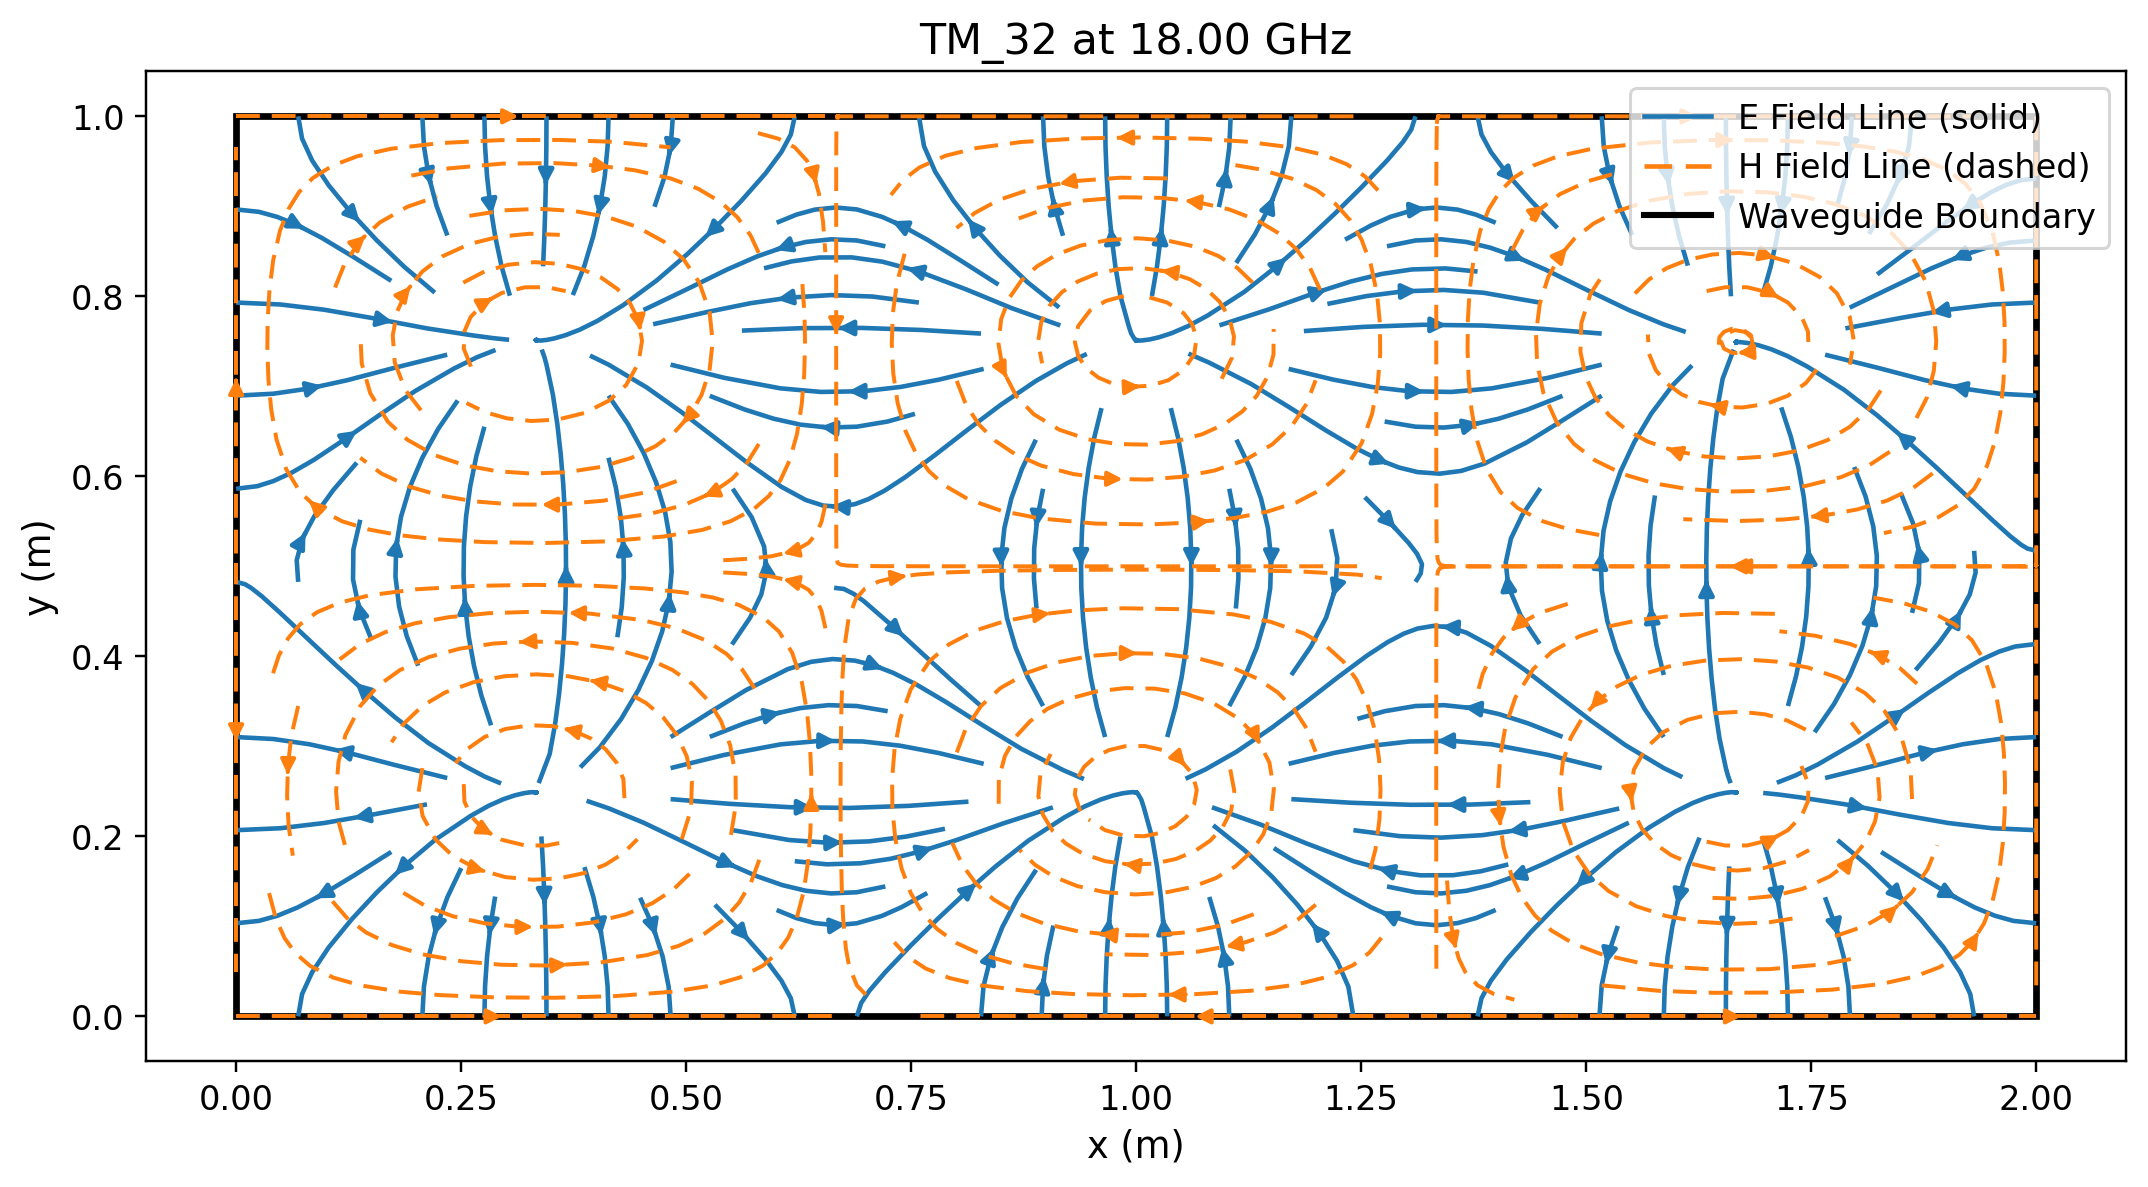

In [30]:
# TM11 模式示意
plot_waveguide_mode(
    mode="TM",
    m=3,
    n=2,
    a=2,
    b=1,
    freq=18e9,
    amplitude=1.0,
    grid=180,
    density=1,
    phase=np.pi / 4,
);